<a href="https://colab.research.google.com/github/Nafisa54/30-Days-of-Python/blob/main/EasyNaira_Reviews_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# =========================
# 1. Import Libraries
# =========================
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

# Set style
sns.set_theme(style="whitegrid")

In [2]:
# =========================
# 2. Fetch EasyNaira App Info
# =========================
app_name = "EasyNaira"
country = "ng"
search_url = f"https://itunes.apple.com/search?term={app_name}&country={country}&entity=software"
resp = requests.get(search_url)
data = resp.json()

if data['resultCount'] == 0:
    raise Exception("App not found!")

info = data['results'][0]
app_id = info['trackId']
print("App Name:", info['trackName'])
print("Developer:", info.get('sellerName'))
print("App ID:", app_id)


App Name: EasyNaira: Fast & Secure Loans
Developer: BETHEONE LENDING NIGERIA LIMITED
App ID: 6744527029


In [3]:
# =========================
# 3. Fetch Reviews (RSS API)
# =========================
reviews = []
for page in range(1, 5):  # adjust page range for more reviews
    reviews_url = f"https://itunes.apple.com/{country}/rss/customerreviews/page={page}/id={app_id}/sortBy=mostRecent/json"
    r = requests.get(reviews_url)
    if r.status_code != 200:
        break
    feed = r.json()
    entries = feed.get('feed', {}).get('entry', [])
    if len(entries) <= 1:
        break
    for entry in entries[1:]:
        reviews.append({
            "user": entry['author']['name']['label'],
            "rating": int(entry['im:rating']['label']),
            "title": entry['title']['label'],
            "review": entry['content']['label'],
            "date": entry['updated']['label']
        })

df = pd.DataFrame(reviews)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
print(f"Fetched {len(df)} reviews")
df.head()


Fetched 52 reviews


,user,rating,title,review,date
0,Expensive kira,5,Scam,I applied for loan after putting all the neces...,2025-09-03 02:19:45-07:00
1,Gifhsbdidjn,1,Bad customer service,My due date have not reach the customer servic...,2025-09-01 06:18:15-07:00
2,Solo@snares,1,Worst app,If you have see all the reviews and u went ahe...,2025-08-28 07:55:43-07:00
3,Abike2222,1,Said they paid to my account but I’m yet to re...,I’ve been waiting for over 30mins and I’m yet ...,2025-08-26 11:30:48-07:00
4,Envisage Cleaners,1,Bunch of losers and the real thiefs!!,I will never ever ever recommend you guys to a...,2025-08-21 23:27:22-07:00


In [4]:
# =========================
# 4. Sentiment Analysis
# =========================
def get_sentiment(text):
    analysis = TextBlob(str(text))
    if analysis.sentiment.polarity > 0.1:
        return "Positive"
    elif analysis.sentiment.polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["review"].apply(get_sentiment)

# Save data
df.to_csv("easyNaira_reviews.csv", index=False)
print(df["sentiment"].value_counts())


sentiment
Positive    19
Neutral     18
Negative    15
Name: count, dtype: int64


/tmp/ipython-input-1439093878.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df, palette="Blues")


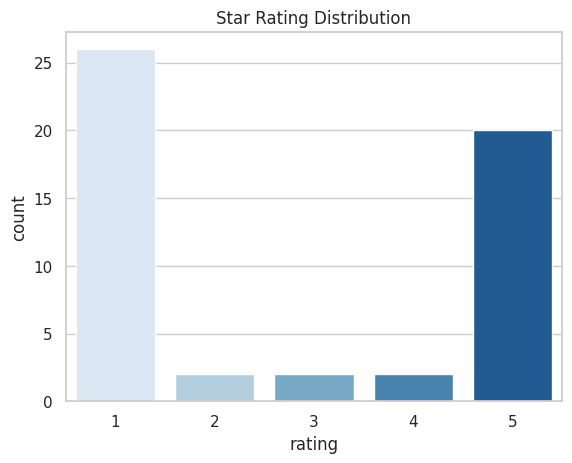

/tmp/ipython-input-1439093878.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, order=["Positive","Neutral","Negative"], palette="Set2")


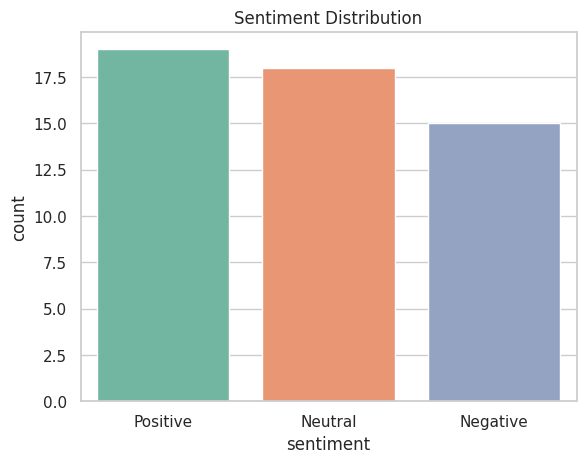

/tmp/ipython-input-1439093878.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["date"].dt.to_period("M")


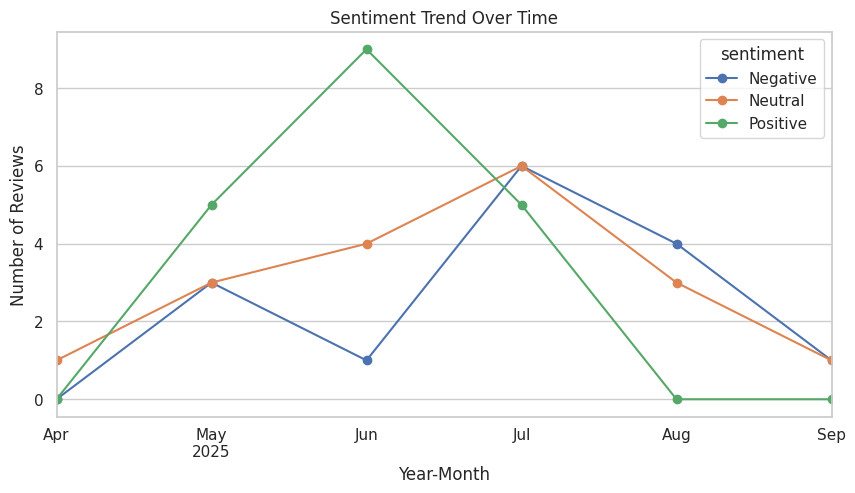

In [5]:
# =========================
# 5. Visualizations
# =========================

# a) Rating Distribution
sns.countplot(x="rating", data=df, palette="Blues")
plt.title("Star Rating Distribution")
plt.show()

# b) Sentiment Distribution
sns.countplot(x="sentiment", data=df, order=["Positive","Neutral","Negative"], palette="Set2")
plt.title("Sentiment Distribution")
plt.show()

# c) Sentiment Over Time
df["year_month"] = df["date"].dt.to_period("M")
trend = df.groupby(["year_month","sentiment"]).size().unstack().fillna(0)
trend.plot(kind="line", marker="o", figsize=(10,5))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.show()


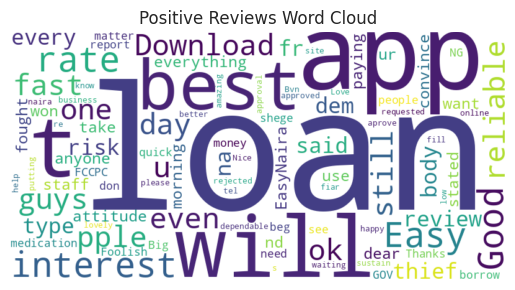

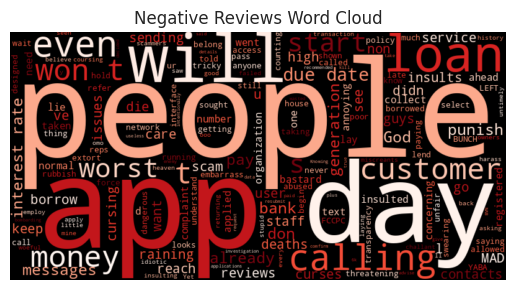

In [6]:
# =========================
# 6. Word Clouds
# =========================

# Positive reviews
positive_text = " ".join(df[df["sentiment"]=="Positive"]["review"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

# Negative reviews
negative_text = " ".join(df[df["sentiment"]=="Negative"]["review"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()


In [7]:
# =========================
# 7. Insights Summary
# =========================
print("📊 Total Reviews:", len(df))
print("⭐ Average Rating:", df["rating"].mean())
print("\nSentiment Breakdown:\n", df["sentiment"].value_counts(normalize=True)*100)

print("\n✅ Next Steps:")
print("- Check what issues dominate negative reviews (repayment, customer service, etc.)")
print("- Compare with competitor apps like PalmPay, FairMoney, Carbon")
print("- Create a dashboard in Power BI / Streamlit")


📊 Total Reviews: 52
⭐ Average Rating: 2.769230769230769

Sentiment Breakdown:
 sentiment
Positive    36.538462
Neutral     34.615385
Negative    28.846154
Name: proportion, dtype: float64

✅ Next Steps:
- Check what issues dominate negative reviews (repayment, customer service, etc.)
- Compare with competitor apps like PalmPay, FairMoney, Carbon
- Create a dashboard in Power BI / Streamlit
